In [1]:
from System import System
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import permutations

In [10]:
def plot_production(sys, return_stats=False):
    machine_dat = sys.machine_data[['time']+['M{} forced idle'.format(m) for m in range(sys.M)]].fillna(0)
    machine_dat = machine_dat[machine_dat['time'] >= 0]
    
    b = sys.bottleneck
    
    bottleneck_uptime = sys.machine_data[['time', 'M{} functional'.format(b)]].fillna(1)
    bottleneck_uptime = bottleneck_uptime[bottleneck_uptime['time'] >= 0]
    
    dat = sys.machine_data[['time','M{} functional'.format(1)]].fillna(1)
    dat = dat[dat['time'] >= 0]
    dat = sum(1-dat['M1 functional'])
    
    
    lp_time = max([0, sum(machine_dat['M{} forced idle'.format(b)]) + dat - 1])#sum(1-bottleneck_uptime['M{} functional'.format(b)])
    lp_units = lp_time / sys.process_times[b]
    
    if return_stats:
        return lp_time, lp_units
        
    plt.figure(figsize=(12,6))
    dat = sys.production_data[sys.production_data['time'] >= 0]
    for m in range(sys.M):
        plt.plot(dat['time'], dat['M{} production'.format(m)], lw=3, label='M{}'.format(m))
    x = np.array([0, max(dat['time'])])
    y = x / max(sys.process_times)
    plt.plot(x, y, label='Ideal production')
    plt.xlabel('time')
    plt.ylabel('production')
    plt.legend(fontsize=16)
    plt.grid()
    plt.show()
    
    print()
    print('Bottleneck machine (M{}) idle for {} time units'.format(b, lp_time))
    print('{} units of lost production'.format(lp_units))

## One machine with planned failure

In [5]:
sys1 = System(process_times=[3], degradation=[0], buffer_sizes=0,
              planned_failures=[(0,10,30)])
sys1.simulate(sim_time=100)

Simulation complete in 0.16s


In [4]:
#sys1.production_data[:20]

In [19]:
sys1.maintenance_data

,time,machine,type,activity,duration
20,20,0,None,repair,10


In [6]:
plot_production(sys1)

KeyError: "['M1 functional'] not in index"

## Two machines with overlapping failures

In [3]:
sys2 = System(process_times=[3, 5], degradation=[0]*2, buffer_sizes=2,
              planned_failures=[(0,10,30), (1, 50, 10)])
sys2.simulate(sim_time=100, warmup_time=500)

Simulation complete in 1.00s


In [7]:
sys2.machines[1].planned_failures

[(1, 550, 10)]

In [5]:
sys2.maintenance_data

,time,machine,type,activity,duration
540,40,0,None,repair,30
560,60,1,None,repair,10


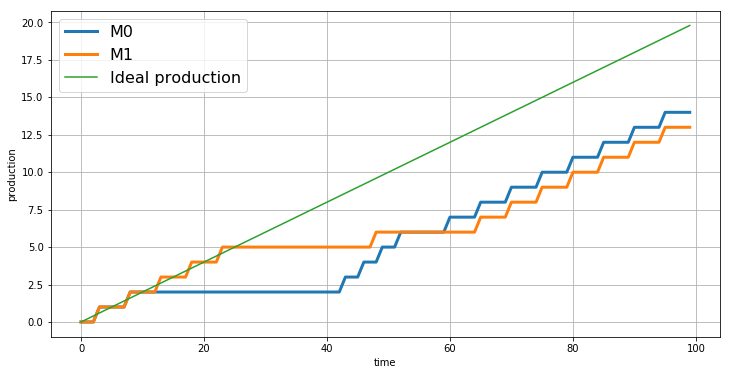


Bottleneck machine (M1) idle for 31 time units
6.2 units of lost production


In [4]:
plot_production(sys2)

In [2]:
#sys2.machine_data[sys2.machine_data['time'] >= 0]

In [39]:
sys2_forced_idle = sys2.machine_data[['M{} forced idle'.format(m) for m in range(sys2.M)]].fillna(0)

In [42]:
sys2.production_data.to_csv('sys2_production.csv')
sys2_forced_idle.to_csv('sys2_idle.csv')
sys2.state_data.to_csv('sys2_state.csv')

## Ordering of three failures

In [13]:
'''
M0: (0, ?, 20)
M1: (1, ?, 25)
M2: (2, ?, 45)
'''
jobs = {0: 15,
        1: 20,
        2: 5}

for job_order in permutations([0, 1, 2]):
    first, second, third = job_order
    
    first_start = 10
    second_start = first_start + jobs[first]
    third_start = second_start + jobs[second]
    
    failures = [(first, first_start, jobs[first]),
                (second, second_start, jobs[second]),
                (third, third_start, jobs[third])]
    
    sys3 = System(process_times=[3, 5, 2], degradation=[0]*3, buffer_sizes=1,
                  planned_failures=failures)#[(first, first_start, 20), (job2, 30, 25), (job3, 55, 45)])
    sys3.simulate(sim_time=200, warmup_time=500, verbose=False)
    
    lp_time, lp_units = plot_production(sys3, return_stats=True)
    
    print('Order: {}, bottleneck idle for {} units'.format(job_order, lp_time))

Order: (0, 1, 2), bottleneck idle for 20 units
Order: (0, 2, 1), bottleneck idle for 31 units
Order: (1, 0, 2), bottleneck idle for 29 units
Order: (1, 2, 0), bottleneck idle for 29 units
Order: (2, 0, 1), bottleneck idle for 20 units
Order: (2, 1, 0), bottleneck idle for 29 units


In [6]:
# service first machine first
sys5 = System(process_times=[3, 5, 2], degradation=[0]*3, buffer_sizes=1,
            planned_failures=[(0, 10, 15)])
sys5.simulate(sim_time=200, warmup_time=500, verbose=False)

lp_time, lp_units = plot_production(sys5, return_stats=True)
print('Bottleneck idle for {} units'.format(lp_time))

Bottleneck idle for 10 units


In [7]:
# service second machine (bottlenck) first
sys4 = System(process_times=[3, 5, 2], degradation=[0]*3, buffer_sizes=1,
            planned_failures=[(1, 10, 20)])
sys4.simulate(sim_time=200, warmup_time=500, verbose=False)

lp_time, lp_units = plot_production(sys4, return_stats=True)
print('Bottleneck idle for {} units'.format(lp_time))

Bottleneck idle for 20 units


In [8]:
# service third machine first
sys6 = System(process_times=[3, 5, 2], degradation=[0]*3, buffer_sizes=1,
            planned_failures=[(2, 10, 5)])
sys6.simulate(sim_time=200, warmup_time=500, verbose=False)

lp_time, lp_units = plot_production(sys6, return_stats=True)
print('Bottleneck idle for {} units'.format(lp_time))

Bottleneck idle for -1 units


In [87]:
sum(sys4.machine_data[sys4.machine_data['time'] >=0]['M1 forced idle'].fillna(0))

0

In [3]:
#sys4.machine_data[sys4.machine_data['time'] >= 0]

In [58]:
sum(sys6.machine_data[sys6.machine_data['time'] >= 0]['M1 forced idle'].fillna(0))

3

In [54]:
sys5 = System(process_times=[3, 5, 2], degradation=[0]*3, buffer_sizes=20, planned_failures=[(0,0,0)], initial_buffer=[10,10])
sys5.simulate(sim_time=480, warmup_time=0, verbose=False)

# get transition points
transitions = []
for m in range(sys5.M):
    if m == sys5.bottleneck:
        transitions += [None]
    else:
        tran_time = sys5.production_data['time'][sys5.production_data.groupby('M{} production'.format(m))['M{} production'.format(m)].transform('count').diff() > 0].values[0]
        transitions += [tran_time]

In [43]:
transitions

[153, None, 30]

In [38]:
sys5.production_data['time'][sys5.production_data.groupby('M2 production')['M2 production'].transform('count').diff() > 0].values[0]

30

In [19]:
sys5.production_data[20:40]

,time,M0 production,M0 throughput,M1 production,M1 throughput,M2 production,M2 throughput
20,20,6.0,0.300000,3.0,0.150000,10.0,0.500000
21,21,7.0,0.333333,3.0,0.142857,10.0,0.476190
22,22,7.0,0.318182,3.0,0.136364,11.0,0.500000
23,23,7.0,0.304348,4.0,0.173913,11.0,0.478261
24,24,8.0,0.333333,4.0,0.166667,12.0,0.500000
25,25,8.0,0.320000,4.0,0.160000,12.0,0.480000
26,26,8.0,0.307692,4.0,0.153846,13.0,0.500000
27,27,9.0,0.333333,4.0,0.148148,13.0,0.481481
28,28,9.0,0.321429,5.0,0.178571,14.0,0.500000
29,29,9.0,0.310345,5.0,0.172414,14.0,0.482759


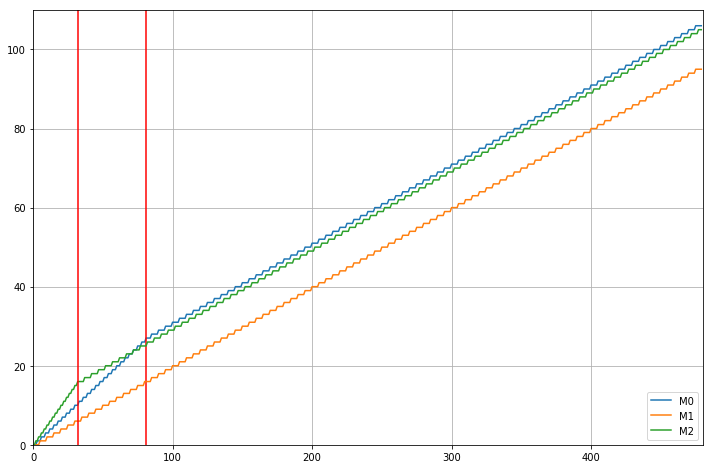

In [59]:
plt.figure(figsize=(12,8))
for m in range(3):
    plt.plot(sys5.production_data['M{} production'.format(m)], label='M{}'.format(m))
    if transitions[m]:
        plt.axvline(x=transitions[m], c='r')
plt.legend()
plt.xlim([0,480])
plt.ylim([0,110])
plt.grid()
plt.show()

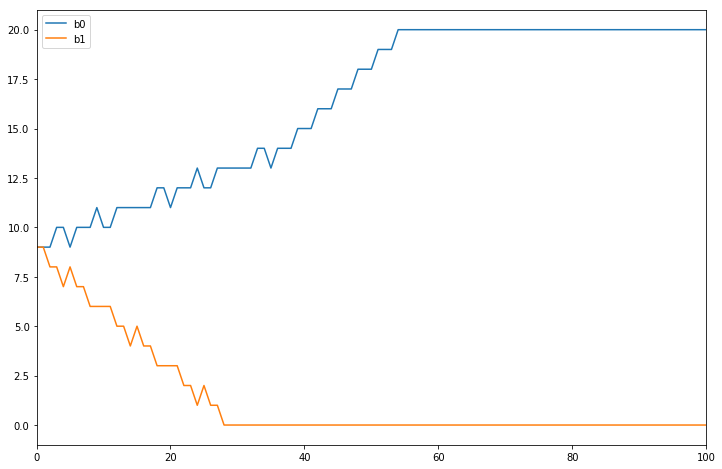

In [67]:
plt.figure(figsize=(12,8))
for b in range(2):
    plt.plot(sys5.state_data['b{} level'.format(b)], label='b{}'.format(b))
plt.xlim([0,100])
plt.legend()
plt.show()

In [63]:
sys5.state_data.head()

,time,M0 has part,b0 level,M1 has part,b1 level,M2 has part
0,0,1,9,1,9,1
1,1,1,9,1,9,1
2,2,1,9,1,8,1
3,3,1,10,1,8,1
4,4,1,10,1,7,1


In [64]:
sys5 = System(process_times=[3, 5, 2], degradation=[0]*3, buffer_sizes=20, 
              planned_failures=[(0,200,2),
                                (1,40,19),
                                (2,100,17)], 
              initial_buffer=[10,10])
sys5.simulate(sim_time=480, warmup_time=0, verbose=False)

# get transition points
transitions = []
for m in range(sys5.M):
    if m == sys5.bottleneck:
        transitions += [None]
    else:
        tran_time = sys5.production_data['time'][sys5.production_data.groupby('M{} production'.format(m))['M{} production'.format(m)].transform('count').diff() > 0].values[0]
        transitions += [tran_time]

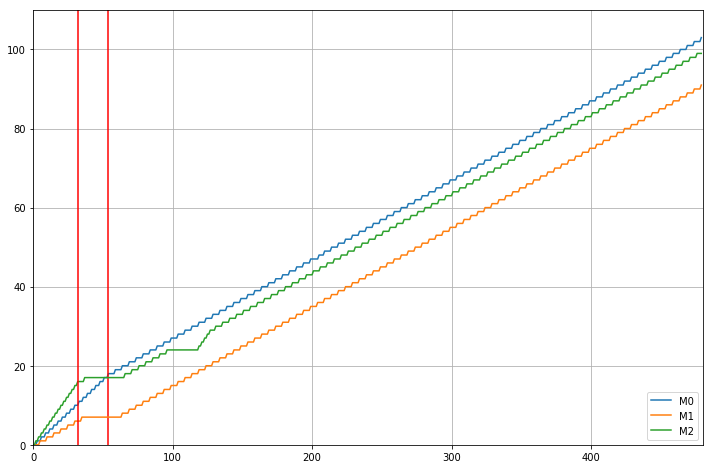

In [65]:
plt.figure(figsize=(12,8))
for m in range(3):
    plt.plot(sys5.production_data['M{} production'.format(m)], label='M{}'.format(m))
    if transitions[m]:
        plt.axvline(x=transitions[m], c='r')
plt.legend()
plt.xlim([0,480])
plt.ylim([0,110])
plt.grid()
plt.show()

In [66]:
sys5.production_data.tail()

,time,M0 production,M0 throughput,M1 production,M1 throughput,M2 production,M2 throughput
475,475,102.0,0.214737,90.0,0.189474,98.0,0.206316
476,476,102.0,0.214286,90.0,0.189076,99.0,0.207983
477,477,102.0,0.213836,90.0,0.188679,99.0,0.207547
478,478,102.0,0.213389,90.0,0.188285,99.0,0.207113
479,479,103.0,0.215031,91.0,0.189979,99.0,0.206681


In [68]:
sys5.maintenance_data

,time,machine,type,activity,duration
59,59,1,None,repair,19
117,117,2,None,repair,17
202,202,0,None,repair,2


In [2]:
sys5 = System(process_times=[3, 5, 2], degradation=[0]*3, buffer_sizes=1, 
              planned_failures=[(0,35,15),
                                (2,30,5),
                                (1,50,20)], 
              initial_buffer=[0,0])
sys5.simulate(sim_time=80, warmup_time=0, verbose=False)

# get transition points
transitions = []
for m in range(sys5.M):
    if m == sys5.bottleneck:
        transitions += [None]
    else:
        tran_time = sys5.production_data['time'][sys5.production_data.groupby('M{} production'.format(m))['M{} production'.format(m)].transform('count').diff() > 0].values[0]
        transitions += [tran_time]

C:\Users\mhoff\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [8]:
sys5.production_data.to_csv('C:/Users/mhoff/Downloads/output.csv')

In [3]:
sys5.maintenance_data

,activity,duration,machine,time,type
0,NaN,NaN,NaN,0,NaN
1,NaN,NaN,NaN,1,NaN
2,NaN,NaN,NaN,2,NaN
3,NaN,NaN,NaN,3,NaN
4,NaN,NaN,NaN,4,NaN
5,NaN,NaN,NaN,5,NaN
6,NaN,NaN,NaN,6,NaN
7,NaN,NaN,NaN,7,NaN
8,NaN,NaN,NaN,8,NaN
9,NaN,NaN,NaN,9,NaN


In [7]:
new_failure = pd.DataFrame({'time':[10],
                                            'machine':[1],
                                            'type':['planned'],
                                            'activity':['failure']})

In [8]:
new_failure

,time,machine,type,activity
0,10,1,planned,failure


In [2]:
sys5 = System(process_times=[3, 5, 2], degradation=[0]*3, buffer_sizes=1, 
              planned_failures=[(1,2,10)], 
              initial_buffer=[0,0])
sys5.simulate(sim_time=30, warmup_time=0, verbose=False)

In [3]:
sys5.maintenance_data

,time,machine,type,activity,duration
0,2,1,planned,failure,
1,12,1,planned,repair,10
